<div align="center">
<h1 style="color:rgb(47,84,150);">Appendix</h1>
</div>

In [10]:
# Import necessary packages and modules
from PIL import Image
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os

In [11]:
# File path-related constants
Image_Path = "" # your path to the images folder

# Image-related constants
Image_Height = 484
Image_Width = 644
File_Extension = '.bmp'
Cropped_Left = int(Image_Width*0.45)
Cropped_Right = int(Image_Width*0.85)
Cropped_Top = int(Image_Height*0.1)
Cropped_Bottom = int(Image_Height*0.65)

# Signal related constants
Min_Wavelength = 470
Max_Wavelength = 740
Num_Wavelengths = 271
Wavelengths = np.linspace(Min_Wavelength, Max_Wavelength, Num_Wavelengths)


In [12]:
# Function used to return the Gray values (i.e. intensity) of a specific pixel for a given image
def gray_values(wavelength, pixel):
    # print(f'Extracting the gray values for image at {image_path}\n(Target pixel: {pixel}')
    this_image_path = os.path.join(Image_Path, str(int(wavelength)) + '.bmp')
    this_image = Image.open(this_image_path)
    rgb = this_image.getpixel(pixel)
    gray = sum(rgb[:3])
    return gray

In [13]:
# Parameters
Sampling_Factor = 10
Testing_Ratio = 0.2                 # Proportion of data points to be considered for testing
seed = 180923
Num_Folds = 5                       # Number of folds for k-cross validation
k = 5
show_folds = False

In [14]:
# Constants
Num_Pixels = Sampling_Factor**2
inter_num = Num_Wavelengths*k
Num_Testing_Signals = int(Testing_Ratio*inter_num)
Num_TrainNVal_Signals = Num_Wavelengths - Num_Testing_Signals

<div align="center">
    <h2 style="color:rgb(47,84,150);">Preprocessing</h2>
</div>


In [15]:
# Construct NumPy array containing an evenly spaced set of points corresponding to pixels on the image
x_coords = np.linspace(Cropped_Left, Cropped_Right, Sampling_Factor)
y_coords = np.linspace(Cropped_Top, Cropped_Bottom, Sampling_Factor)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)
pixels = np.column_stack((x_grid.flatten(), y_grid.flatten()))

<div align="center">
    <h3 style="color:rgb(47,84,150);">Interpolation</h3>
</div>


In [16]:
# defining arrays for the feautures and interpolated labels
y_interpolated = np.linspace(Min_Wavelength, Max_Wavelength, inter_num)
X_interpolated= np.zeros((inter_num, Num_Pixels))
X = np.zeros((Num_Wavelengths, Num_Pixels))

for i in range(Num_Wavelengths):
  for j in range(Num_Pixels):
      X[i, j] = gray_values(Wavelengths[i], tuple(pixels[j]))

In [17]:
# Interpolate the feature data for the desired wavelengths
for r in range(Num_Pixels):
   X_interpolated[:,r] = sp.interpolate.UnivariateSpline(Wavelengths, X[:, r])(y_interpolated[:])

# Convert the result to a NumPy array
X_interpolated = np.array(X_interpolated)

<div align="center">
    <h3 style="color:rgb(47,84,150);">Spliting the data</h3>
</div>


In [18]:
# Separate the labels of the dataset into two arrays for training and testing
np.random.seed(seed)
indices = np.random.permutation(inter_num)
y_test = y_interpolated[indices[:Num_Testing_Signals]]
y_trainNval = y_interpolated[indices[Num_Testing_Signals:]]

# Construct the feature arrays for training and testing
X_trainNVal = X_interpolated[indices[Num_Testing_Signals:],:]
X_test = X_interpolated[indices[:Num_Testing_Signals],:]

<div align="center">
    <h3 style="color:rgb(47,84,150);">Normalization</h3>
</div>

In [19]:
# Normalizing the data

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on training data and transform it
X_train_scaled = scaler.fit_transform(X_trainNVal)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

<div align="center">
    <h2 style="color:rgb(47,84,150);">Linear Regression</h2>
</div>


In [20]:
# Perform KFold cross-validation
kf = KFold(n_splits=Num_Folds)
mse_scores = []

for fold_num, (train_index, val_index) in enumerate(kf.split(X_train_scaled)):
    X_train, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train, y_val = y_trainNval[train_index], y_trainNval[val_index]

    # Create a Linear Regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_val)

    # Caclulate Mean Squared Error (MSE) for this fold
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)
    if mse == min(mse_scores):
       best_fold = fold_num
       y_test_pred = model.predict(X_test_scaled)


    if show_folds:
        plt.scatter(y_val, y_pred, color='blue')
        plt.xlabel('True Wavelength')
        plt.ylabel('Predicted Wavelength')
        plt.title(f'Predicted Wavelength vs True Wavelength (Fold: {fold_num})')
        plt.show()
mean_mse = np.mean(mse_scores)
print('Mean MSE across all folds:', mean_mse)

Mean MSE across all folds: 82.49780763983922


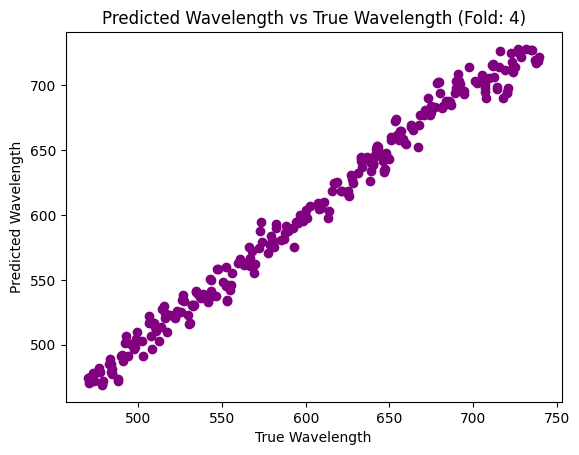

In [21]:
plt.scatter(y_test, y_test_pred, color='purple')
plt.xlabel('True Wavelength')
plt.ylabel('Predicted Wavelength')
plt.title(f'Predicted Wavelength vs True Wavelength (Fold: {best_fold})')
plt.show()